
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [424]:
import time
import math

import numpy as np
import pandas as pd

from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *
from services.big_m_strategies import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
imputation_method = 'Multivariate'
ticker_str = 'AAPL'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [425]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [426]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [427]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [428]:
start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

# start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
#
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [429]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [430]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [431]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [432]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [433]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [452]:
def exponential_weighted_estimator(daily_prices, k, alpha=1 - 0.985):
    # Use this function to perform naive sample estimation
    # ----------------------------------------------------------------------
    daily_log_returns = np.log(daily_prices).diff().dropna()
    one_day_covariance, one_day_mean = exponential_weighted_average(daily_log_returns, alpha)
    log_transformed_cov, log_transformed_mean = transform_log_stats(one_day_mean, one_day_covariance, k)

    return log_transformed_mean, log_transformed_cov + 0.2*np.eye(log_transformed_cov.shape[0])

In [516]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest)
hyperparam_search = True # True if model has hyperparams
optimizer = SVMMVO # CardMVO , MVO
estimator = exponential_weighted_estimator

k = 6*20 #estimation horizon
alpha= 1 - 0.985 #estimation decay
return_premium = 1.4 #optimization premium

turnover_constraints = True
turnover_limit = 0.75 # 0.75, 1, 1.25
cardinality_ratio = 0.1 #optimization

MipGap = 0.05 # for portfolio optimizer
limit_time = 20 # for portfolio optimizer

target_return_strategy = premium_target # for portfolio optimizer to calculate return target
# mean_target, premium_target, ticker_return_target
target_return_strategy_args = ['premium'] # args for the return strategy

bigMStrategy = objectiveBigMStrategy #objectiveBigMStrategyTightening , objectiveBigMStrategy

bigM_limit_time=5 # for the feasible solution used to calculate big M
bigM_MipGap=0.1 # for the feasible solution used to calculate big M
bigM_SolutionLimit=10 # for the feasible solution used to calculate big <

SkipSOCP = True # flag to skip the SOCP
tightening_iter_lim = 1 # number of iterations of tightening to do

SVMMVO_bigM_time_limit = 5 # for computing a better solution in the tightening strategy
SVMMVO_MipGap=0.1 # for computing a better solution in the tightening strategy
SVMMVO_SolutionLimit=5 # for computing a better solution in the tightening strategy

SOCP_limit_time=10 # time limit for the SOCP's

ticker_index = tickers.get_loc(ticker_str) # the ticker we want to compare to if
#  we are using the ticker_return_target strategy

q = 2 #subset of features

C = 0.1 # separation importance

epsilon = 0.1 # regularization amount for SVM

separable = False # do not restrict the hyperplane to be separable

LogToConsole = True # display optimization results in the console
Verbose = True # print statements

hyperparams = {'C': list(np.geomspace(0.1, 100, 4)), 'epsilon': list(np.geomspace(0.1, 100, 4))} # hyperparams for hyperparam search
#q_alpha = 0.3187 # alpha for Q(t, a) = (1 - q_alpha) Q(t-1. a) + R(t, a)
q_alpha = 0.6838
kappa = 0.5 # 10 % risk/turnover tolerance

investor_preferences = {'k':k, # horizon
                        'alpha':alpha, # decay
                        'premium':return_premium, # return premium preference
                        'ticker_index':ticker_index, # benchmark index for comparison used in place of return premium depending on the investors function to set r_min
                        'target_return_strategy':target_return_strategy, # strategy for setting return
                        'target_return_strategy_args': target_return_strategy_args, # args for return setting strategy
                        'turnover_limit':turnover_limit, # turnover limit
                        'turnover_constraints':turnover_constraints, # turnover limit choice (Y/N)
                        'cardinality_ratio': cardinality_ratio, # Pct of assets to invest in
                        'MipGap' : MipGap, 'limit_time':limit_time, # problem solving limits
    
                        'bigMStrategy':bigMStrategy,
                        'bigM_limit_time':bigM_limit_time,
                        'bigM_MipGap':bigM_MipGap,
                        'bigM_SolutionLimit':bigM_SolutionLimit,

                        'SkipSOCP':SkipSOCP,
                        'tightening_iter_lim':tightening_iter_lim,

                        'SVMMVO_bigM_time_limit':SVMMVO_bigM_time_limit,
                        'SVMMVO_MipGap':SVMMVO_MipGap,
                        'SVMMVO_SolutionLimit':SVMMVO_SolutionLimit,

                        'SOCP_limit_time':SOCP_limit_time,
                        'q':q,
                        'C':C,
                        'epsilon':epsilon,
                        'separable':separable,
                        'LogToConsole':LogToConsole,
                        'Verbose':Verbose,
                        'hyperparams':hyperparams,
                        'q_alpha':q_alpha,
                        'kappa':kappa}

Strategy = general_strategy(estimator, optimizer,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator
Strategy.extract_optimization_info = populate_kwargs

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [517]:

# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

# End of the first investment period
# testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [518]:
Strategy.current_estimates[1].diagonal().mean()

TypeError: 'NoneType' object is not subscriptable

In [519]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 1998-12-31 00:00:00
Test End 1999-05-31 00:00:00
Calibration End 1998-12-30 00:00:00


In [520]:
import gurobipy as gp
from gurobipy import GRB
import time
from services.data_utils import *
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss
# Cardinality Constrained Optimization
def CreateCardMVOModel(mu, targetRet, Q, K, limit_time=30, MipGap=0.01, LogToConsole=True):
    n = len(mu)

    m = gp.Model("miqp")

    m.Params.timeLimit = limit_time

    m.Params.MIPGap = MipGap

    m.Params.LogToConsole = int(LogToConsole)

    z_vars = m.addMVar(n, vtype=gp.GRB.BINARY, name="z_vars")

    x_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="x_vars")

    m.setObjective(x_vars @ Q @ x_vars, gp.GRB.MINIMIZE)

    m.addConstr(x_vars.sum() == 1)

    m.addConstr(mu @ x_vars >= targetRet)

    m.addConstr(z_vars.sum() <= K)

    m.addConstr(x_vars <= z_vars)

    return m, x_vars, z_vars


def extractSolution(n, m, x_vars, z_vars):
    x = np.zeros(n)
    z = np.zeros(n)
    for i in range(n):
        x[i] = x_vars[i].X
        z[i] = z_vars[i].X
    obj_value = m.objVal
    gap1 = m.MIPGap
    gap2 = gap1 * 100
    return obj_value, gap2, x, z


def addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit):
    n = len(previous_portfolio)
    absolute_delta = m.addMVar(n, lb=-GRB.INFINITY, ub=GRB.INFINITY,
                               vtype=gp.GRB.CONTINUOUS, name="magnitude of portfolio changes")
    m.addConstr(absolute_delta >= x_vars - previous_portfolio)
    m.addConstr(absolute_delta >= previous_portfolio - x_vars)
    m.addConstr(absolute_delta.sum() <= turnover_limit, name='turnover')
    m.update()
    return absolute_delta


def smallestTurnoverModel(m, absolute_delta):
    # compute the smallest turnover portfolio instead of the smallest risk with turnover constraints
    m.remove(m.getConstrByName('turnover'))
    m.reset()
    m.setObjective(absolute_delta.sum())
    m.optimize()


def CardMVO(limit_time=30, MipGap=0.01, SolutionLimit=GRB.MAXINT,
            LogToConsole=True, Verbose=True, **kwargs):
    mu, Q, K, targetRet = kwargs['mu'], kwargs['Q'], kwargs['K'], kwargs['targetRet']
    turnover_constraints = kwargs['turnover_constraints']
    previous_portfolio = kwargs['previous_portfolio']
    if turnover_constraints:
        turnover_limit = kwargs['turnover_limit']

    feasible_solution = True

    n = len(mu)
    mu = mu.squeeze()

    start = time.time()

    m, x_vars, z_vars = CreateCardMVOModel(mu, targetRet, Q, K, limit_time, MipGap, LogToConsole)

    m.Params.SolutionLimit = SolutionLimit

    if previous_portfolio is not None and turnover_constraints:
        absolute_delta = addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit)

    if Verbose:
        print("-" * 20)
        print("Solving Card MVO...")
    m.optimize()

    # model did not solve
    if m.status in (4, 3):
        feasible_solution = False
        if previous_portfolio is not None and turnover_constraints:
            if Verbose:
                print("Computing lowest turnover feasible solution...")
            smallestTurnoverModel(m, absolute_delta)

    obj_value, gap2, x, z = extractSolution(n, m, x_vars, z_vars)

    end = time.time()
    if Verbose:
        print("Card MVO Finished...")
        print("-" * 20)

    return {'obj_value': obj_value, 'time': end - start,
            'optimality gap': gap2, 'x': x, 'z': z, 'feasible_solution': feasible_solution}


def CreateSVMMVOModel(mu, targetRet, Q, K, q, epsilon,
                      bigM, big_w_inf,
                      period_Context, C, separable, limit_time, MipGap, LogToConsole):
    n, p = period_Context.shape

    m = gp.Model("miqp")

    m.Params.timeLimit = limit_time

    m.Params.MIPGap = MipGap

    m.Params.LogToConsole = int(LogToConsole)

    # binary variables
    z_vars = m.addMVar(n, vtype=gp.GRB.BINARY, name="z_vars")

    t_vars = m.addMVar(p, vtype=gp.GRB.BINARY, name="t_vars")

    x_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="x_vars")

    w_vars = m.addMVar(p, lb=-1 * GRB.INFINITY, ub=GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="w_vars")

    b_var = m.addMVar(shape=1, lb=-1 * GRB.INFINITY, name="b_var", vtype=gp.GRB.CONTINUOUS)

    m.addConstr(x_vars.sum() == 1)

    m.addConstr(mu @ x_vars >= targetRet)

    m.addConstr(z_vars.sum() <= K)

    m.addConstr(x_vars <= z_vars)

    if separable:
        xi_vars = None
        m.setObjective(x_vars @ Q @ x_vars + (epsilon / 2) * (w_vars @ w_vars), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr(w_vars @ y_i + b_var <= -1 + bigM * z_vars[i], name="svm1")
            m.addConstr(w_vars @ y_i + b_var >= 1 + bigM * (1 - z_vars[i]), name="svm2")
    else:
        xi_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="xi_vars")
        C_epsilon_by_n = C * epsilon / n
        m.setObjective(x_vars @ Q @ x_vars + (epsilon / 2) * (w_vars @ w_vars) + C_epsilon_by_n * xi_vars.sum(),
                       gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr(w_vars @ y_i + b_var <= -1 + xi_vars[i] + bigM * z_vars[i], name="svm1")
            m.addConstr(w_vars @ y_i + b_var >= 1 - xi_vars[i] - bigM * (1 - z_vars[i]), name="svm2")

    m.addConstr(w_vars <= big_w_inf * t_vars)

    m.addConstr(w_vars >= -1 * big_w_inf * t_vars)

    m.addConstr(t_vars.sum() <= q)

    return m, x_vars, z_vars, w_vars, b_var, t_vars, xi_vars


def CreateSVMModel(period_Context, z_vals, C, separable, limit_time, LogToConsole):
    n, p = period_Context.shape

    m = gp.Model("miqp")

    m.Params.timeLimit = limit_time

    m.Params.LogToConsole = int(LogToConsole)

    w_vars = m.addMVar(p, lb=-1 * GRB.INFINITY, ub=GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="w_vars")

    b_var = m.addMVar(shape=1, lb=-1 * GRB.INFINITY, name="b_var", vtype=gp.GRB.CONTINUOUS)

    if separable:
        xi_vars = None
        m.setObjective((1 / 2) * (w_vars @ w_vars), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr((2 * z_vals[i] - 1) * (y_i @ w_vars + b_var) >= 1)
    else:
        xi_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="xi_vars")
        C_by_n = C / n
        m.setObjective((1 / 2) * (w_vars @ w_vars) + C_by_n * xi_vars.sum(), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr((2 * z_vals[i] - 1) * (y_i @ w_vars + b_var) + xi_vars[i] >= 1)
    return m, w_vars, b_var, xi_vars


def extractSVMSolution(n, p, m, w_vars, b_var, xi_vars):
    w = np.zeros(p)
    b = np.zeros(1)
    xi = np.zeros(n)
    for i in range(p):
        w[i] = w_vars[i].X
    b[0] = b_var[0].X

    for i in range(n):
        if xi_vars is not None:
            xi[i] = xi_vars[i].X

    obj_value = m.objVal

    return obj_value, w, b, xi


def SVM(period_Context, z_vals, C, separable, limit_time, LogToConsole):
    n, p = period_Context.shape

    m, w_vars, b_var, xi_vars = CreateSVMModel(period_Context, z_vals, C, separable, limit_time, LogToConsole)
    start = time.time()
    m.optimize()
    end = time.time()
    obj_value, w, b, xi = extractSVMSolution(n, p, m, w_vars, b_var, xi_vars)

    return {'obj_value': obj_value, 'time': end - start, 'w': w, 'b': b, 'xi': xi}

def sklearn_SVM(period_Context, z_vals, C, separable):
    if separable is True:
        warnings.warn("SVM is no longer separable")

    n, p = period_Context.shape

    svc = SVC(C = C/n, kernel = 'linear')
    u = 2*z_vals - 1
    start = time.time()
    svc.fit(period_Context, u)
    end = time.time()
    w = np.squeeze(svc.coef_)
    b = svc.intercept_
    pred_decision = svc.decision_function(period_Context)
    margin = u*pred_decision
    xi = np.maximum(0, 1 - margin)
    obj_value = (1 / 2)*np.power(w, 2).sum() + C*np.mean(xi)

    return {'obj_value': obj_value, 'time': end - start, 'w': w, 'b': b, 'xi': xi, 'svc': svc}


def CreateBestSubsetSVMModel(period_Context, z_vals, C, separable, q, big_w2, limit_time, LogToConsole):
    n, p = period_Context.shape

    m = gp.Model("miqp")

    m.Params.timeLimit = limit_time

    m.Params.LogToConsole = int(LogToConsole)

    w_vars = m.addMVar(p, lb=-1 * GRB.INFINITY, ub=GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="w_vars")
    t_vars = m.addMVar(p, vtype=gp.GRB.BINARY, name="t_vars")

    b_var = m.addMVar(shape=1, lb=-1 * GRB.INFINITY, name="b_var", vtype=gp.GRB.CONTINUOUS)

    if separable:
        xi_vars = None
        m.setObjective((1 / 2) * (w_vars @ w_vars), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr((2 * z_vals[i] - 1) * (y_i @ w_vars + b_var) >= 1)
    else:
        xi_vars = m.addMVar(n, lb=0.0, vtype=gp.GRB.CONTINUOUS, name="xi_vars")
        C_by_n = C / n
        m.setObjective((1 / 2) * (w_vars @ w_vars) + C_by_n * xi_vars.sum(), gp.GRB.MINIMIZE)
        for i in range(n):
            y_i = period_Context.iloc[i].values
            m.addConstr((2 * z_vals[i] - 1) * (y_i @ w_vars + b_var) + xi_vars[i] >= 1)

    m.addConstr(t_vars.sum() <= q)

    m.addConstr(w_vars <= big_w2*t_vars)
    m.addConstr((-1)*w_vars <= big_w2*t_vars)

    return m, w_vars, b_var, xi_vars, t_vars

def BestSubsetSVM(period_Context, z_vals, C, separable, q, big_w2, limit_time, LogToConsole):

    n, p = period_Context.shape

    m, w_vars, b_var, xi_vars, t_vars = CreateBestSubsetSVMModel(period_Context, z_vals, C, separable, q, big_w2, limit_time, LogToConsole)
    start = time.time()
    m.optimize()
    end = time.time()
    obj_value, w, b, xi = extractSVMSolution(n, p, m, w_vars, b_var, xi_vars)

    return {'obj_value': obj_value, 'time': end - start, 'w': w, 'b': b, 'xi': xi}

def extractSVMMVOSolution(n, p, m, x_vars, z_vars, w_vars, t_vars, b_var, xi_vars):
    x = np.zeros(n)
    z = np.zeros(n)
    w = np.zeros(p)
    t = np.zeros(p)
    b = np.zeros(1)
    xi = np.zeros(n)

    for i in range(n):
        x[i] = x_vars[i].X
        z[i] = z_vars[i].X
        if xi_vars is not None:
            xi[i] = xi_vars[i].X

    for i in range(p):
        w[i] = w_vars[i].X
        t[i] = t_vars[i].X
    b[0] = b_var[0].X

    obj_value = m.objVal
    gap1 = m.MIPGap
    gap2 = gap1 * 100
    return obj_value, gap2, x, z, w, t, b, xi


def smallestTurnoverModelSVMMVO(m, n, absolute_delta, separable, w_vars, xi_vars, epsilon, C):

    # compute the smallest turnover portfolio instead of smallest risk with turnover constraints

    m.remove(m.getConstrByName('turnover'))
    m.reset()

    if separable:
        m.setObjective(absolute_delta.sum() + (epsilon / 2) * (w_vars @ w_vars), gp.GRB.MINIMIZE)
    else:
        C_epsilon_by_n = C * epsilon / n
        m.setObjective(absolute_delta.sum() + (epsilon / 2) * (w_vars @ w_vars) + C_epsilon_by_n * xi_vars.sum(),
                       gp.GRB.MINIMIZE)
    m.optimize()


def SVMMVO_check_bigM(user_big_m, LogToConsole, bigMStrategy, Verbose, kwargs):
    if user_big_m is None:
        bigM_kwargs = kwargs.copy()
        bigM_kwargs['LogToConsole'] = LogToConsole
        bigM_kwargs['Verbose'] = Verbose

        big_M_results = bigMStrategy(**bigM_kwargs)
        bigM, big_w_inf, big_b, big_xi = (big_M_results['bigM'], big_M_results['big_w_inf'],
                                          big_M_results['big_b'], big_M_results['big_xi'])
    else:
        assert type(user_big_m) == dict
        big_M_results = user_big_m
        bigM, big_w_inf, big_b, big_xi = user_big_m['bigM'], user_big_m['big_w_inf'], user_big_m['big_b'], user_big_m[
            'big_xi']

    return big_M_results, bigM, big_w_inf, big_b, big_xi


def SVMMVO(limit_time=30, MipGap=0.01, LogToConsole=True, Verbose=True, SolutionLimit=GRB.MAXINT, user_big_m=None,
           **kwargs):  # if kwargs does not have limit time and mipgap then

    mu, targetRet, Q, K, q, epsilon, period_Context, C, separable = unpack_kwargs(kwargs)

    bigMStrategy = kwargs['bigMStrategy']
    turnover_constraints = kwargs['turnover_constraints']
    previous_portfolio = kwargs['previous_portfolio']

    if turnover_constraints:
        turnover_limit = kwargs['turnover_limit']

    feasible_solution = True

    n, p = period_Context.shape
    mu = mu.squeeze()

    start = time.time()
    # compute big M here
    big_M_results, bigM, big_w_inf, big_b, big_xi = SVMMVO_check_bigM(user_big_m, LogToConsole,
                                                                      bigMStrategy, Verbose, kwargs)

    # if epsilon and C in big_M_results --> update epsilon and C: kappa
    # if the big M strategy yields feasibility information then
    # update the feasible solution flag
    if 'feasible_solution' in big_M_results.keys():
        feasible_solution = big_M_results['feasible_solution']

    if Verbose:
        print("Calculated Big M ", bigM)
        print("Calculated big W", big_w_inf)
        print("Calculated big b", big_b)
        print("Calculated big xi", big_xi)

    bigM_finish_time = time.time()

    m, x_vars, z_vars, w_vars, b_var, t_vars, xi_vars = CreateSVMMVOModel(mu, targetRet, Q, K, q, epsilon,
                                                                          bigM, big_w_inf,
                                                                          period_Context, C=C,
                                                                          separable=separable, limit_time=limit_time,
                                                                          MipGap=MipGap, LogToConsole=LogToConsole)
    m.Params.SolutionLimit = SolutionLimit

    if previous_portfolio is not None and turnover_constraints:  # add turnover constraints
        absolute_delta = addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit)

    if feasible_solution:  # if we are feasible to the best of our knowledge
        m.optimize()  # try to solve
        # model did not solve
        if m.status in (4, 3):  # ah turns out we are not feasible
            feasible_solution = False  # update the flag
    else:  # feasible_solution is already set to false
        # it must be because of the turnover constraint
        # compute the min turnover portfolio that satisfies the constraint
        if previous_portfolio is not None and turnover_constraints:
            if Verbose:
                print("Calculating the closest turnover portfolio...")
            smallestTurnoverModelSVMMVO(m, n, absolute_delta, separable, w_vars, xi_vars, epsilon, C)

    obj_value, gap2, x, z, w, t, b, xi = extractSVMMVOSolution(n, p, m, x_vars, z_vars, w_vars, t_vars, b_var, xi_vars)
    if Verbose:
        print("SVM MVO Objective Value ", obj_value)
        print("Norm of w ", np.power(w, 2).sum())
        print("Classification errors ", np.sum(xi))
    end = time.time()
    return {'obj_value': obj_value, 'time': end - start, 'bigM_time': bigM_finish_time - start, 'optimality gap': gap2,
            'x': x, 'z': z, 'w': w, 't': t, 'b': b, 'xi': xi, 'feasible_solution': feasible_solution}


In [521]:
from services.binary_optimization import *
from services.data_utils import *
import warnings
import math


# Big M strategies begin
def ConstructFeasibleMVO(bigM_limit_time=10, bigM_MipGap=0.1, bigM_SolutionLimit=10, LogToConsole=True,
                         Verbose=True, **kwargs):
    # take out args into new dict
    if Verbose:
        print("-" * 20)
        print("Constructing Feasible Solution...")
    bigM_kwargs_forCardMVO = kwargs.copy()
    bigM_kwargs_forCardMVO['limit_time'] = bigM_limit_time
    bigM_kwargs_forCardMVO['MipGap'] = bigM_MipGap
    bigM_kwargs_forCardMVO['SolutionLimit'] = bigM_SolutionLimit
    bigM_kwargs_forCardMVO['LogToConsole'] = LogToConsole
    bigM_kwargs_forCardMVO['Verbose'] = Verbose
    # card mvo
    if Verbose:
        print("Extracting a cardinality constrained portfolio...")
    card_mvo_results = CardMVO(**bigM_kwargs_forCardMVO)
    z_vals = card_mvo_results['z']

    ObjMVO = card_mvo_results['obj_value']

    return ObjMVO, card_mvo_results['feasible_solution'], z_vals


def ConstructFeasibleSolutionSVM(z_vals, period_Context, C, separable, q, bigM_limit_time, LogToConsole, Verbose):
    # take out args into new dict2
    # SVM

    if Verbose:
        print("Phase 1 SVM...")
    #svm_phase1_results = SVM(period_Context, z_vals, C, separable, bigM_limit_time, LogToConsole)
    # print(svm_phase1_results['obj_value'])
    # print(np.power(svm_phase1_results['w'], 2).sum())
    # print(svm_phase1_results['xi'].sum())
    #print(svm_phase1_results['time'])
    svm_phase1_results = sklearn_SVM(period_Context, z_vals, C, separable)
    # print("SKLEARN")
    # print(svm_phase1_results['obj_value'])
    # print(np.power(svm_phase1_results['w'], 2).sum())
    # print(svm_phase1_results['xi'].sum())
    print(svm_phase1_results['time'])
    # sort and clip w
    w_vals = svm_phase1_results['w']
    abs_w = np.abs(w_vals)
    q_largest = np.argpartition(abs_w, (-1) * q)[-q:]
    # restrict indices
    period_Context_subset = period_Context.iloc[:, q_largest]
    # SVM again
    if Verbose:
        print("Phase 2 SVM...")
    svm_phase2_results = sklearn_SVM(period_Context_subset, z_vals, C, separable)
    if Verbose:
        print("Feasible Solution Constructed")
        print("-" * 20)
    # Calculate Objective Value
    ObjSVM = svm_phase2_results['obj_value']
    w = svm_phase2_results['w']
    b = svm_phase2_results['b']

    return ObjSVM, w, b


def unpack_bigM_params(**kwargs):
    if 'bigM_limit_time' in kwargs.keys():
        bigM_limit_time = kwargs['bigM_limit_time']
    else:
        bigM_limit_time = 10
    if 'LogToConsole' in kwargs.keys():
        LogToConsole = kwargs['LogToConsole']
    else:
        LogToConsole = True
    if 'Verbose' in kwargs.keys():
        Verbose = kwargs['Verbose']
    else:
        Verbose = True
    return bigM_limit_time, LogToConsole, Verbose


def ConstructFeasibleSolution(**kwargs):
    period_Context, C, separable = kwargs['period_Context'], kwargs['C'], kwargs['separable']
    q, epsilon = kwargs['q'], kwargs['epsilon']

    # Do Card MVO
    ObjMVO, feasible_solution, z_vals = ConstructFeasibleMVO(**kwargs)

    # SVM
    bigM_limit_time, LogToConsole, Verbose = unpack_bigM_params(**kwargs)

    ObjSVM, w, b = ConstructFeasibleSolutionSVM(z_vals, period_Context, C, separable, q,
                                                bigM_limit_time, LogToConsole, Verbose)

    return ObjMVO + epsilon * ObjSVM, feasible_solution


def ConstructFeasibleSolutionandHyperParams(**kwargs):
    period_Context, separable = kwargs['period_Context'], kwargs['separable']

    q = kwargs['q']
    kappa = kwargs['kappa']

    n, p = period_Context.shape
    # do card MVO
    ObjMVO, feasible_solution, z_vals = ConstructFeasibleMVO(**kwargs)
    u = 2*z_vals - 1
     # SVM
    bigM_limit_time, LogToConsole, Verbose = unpack_bigM_params(**kwargs)

    # find the best C using k fold
    Cs = np.geomspace(2**(-13), 2**13, 27)
    bestC = 2**(-11)
    lowest_error = n # this is an upper bound on the error
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle = True, random_state=20)
    error_list = []
    w_list = []
    for C in Cs:
        errors = np.zeros(n_splits)
        for i, (train_index, test_index) in enumerate(kf.split(period_Context)):
            #print(f"Fold {i}:")
            #print(f"  Train: index={train_index}")
            #print(f"  Test:  index={test_index}")
            # solve SVM
            svm_phase1_results = sklearn_SVM(period_Context.iloc[train_index], z_vals[train_index], C, separable)
            w_vals = svm_phase1_results['w']
            abs_w = np.abs(w_vals)
            q_largest = np.argpartition(abs_w, (-1) * q)[-q:]
            # restrict indices
            period_Context_subset = period_Context.iloc[:, q_largest]
            svm_phase2_results = sklearn_SVM(period_Context_subset.iloc[train_index], z_vals[train_index], C, separable)
            svc = svm_phase2_results['svc']
            pred_decision = svc.decision_function(period_Context_subset.iloc[test_index])
            margin = u[test_index]*pred_decision
            xi_test = np.maximum(0, 1 - margin)
            errors[i] = np.mean(xi_test)
        error_list.append(errors.mean())
        w_list.append(np.power(svm_phase2_results['w'], 2).sum())
        if errors.mean() < lowest_error:
            bestC = C
            if Verbose:
                print("New Best C ", bestC)
                print("Test Error ", errors.mean())
            lowest_error = errors.mean()

    plt.plot(Cs, error_list)
    plt.xscale("log")
    plt.figure()
    plt.plot(Cs, w_list)
    plt.xscale("log")
    # calculate ObjSVM and construct bound on ||w||_1
    svm_phase1_results = sklearn_SVM(period_Context, z_vals, bestC, separable)
    w_vals = svm_phase1_results['w']
    abs_w = np.abs(w_vals)
    q_largest = np.argpartition(abs_w, (-1) * q)[-q:]
    # restrict indices
    period_Context_subset = period_Context.iloc[:, q_largest]
    svm_phase2_results = sklearn_SVM(period_Context_subset, z_vals, bestC, separable)
    # sqrt(2 ObjSVM) is the soln is big_w2 and hence big w
    ObjFeasibleSVM = svm_phase2_results['obj_value']
    big_w2 = math.sqrt(2 * ObjFeasibleSVM)
    # solve BSS SVM
    BestSubsetSVM_results = BestSubsetSVM(period_Context, z_vals, bestC, separable, q, big_w2, limit_time, LogToConsole)
    ObjSVM = BestSubsetSVM_results['obj_value']
    # set epsilon so that the risk guarantee is satisfied
    epsilon = (kappa * ObjMVO)/ObjSVM
    if Verbose:
        print("Largest epsilon value guaranteeing ", 1+kappa, " risk: ", epsilon)


    return ObjMVO + epsilon*ObjSVM, feasible_solution, C, epsilon

def size_of_largest_feature(period_Context, q):
    """
    M_{\mathcal{Y}}
    """
    n, p = period_Context.shape
    largest_abs = 0
    for i in range(n):
        candidate = math.sqrt(np.power(period_Context.iloc[i], 2).sort_values(ascending=False).iloc[:q].sum())
        if candidate > largest_abs:
            largest_abs = candidate
    return largest_abs


def largest_pairwise_distance(period_Context, q):
    """
    """
    n, p = period_Context.shape
    largest_abs_pdist = 0
    pairs = period_Context.values - period_Context.values[:, None]
    pairs = np.power(pairs, 2)
    for i in range(n):
        for j in range(i):
            candidate = math.sqrt(np.sort(pairs[i, j])[-1 * q:].sum())
            if candidate > largest_abs_pdist:
                largest_abs_pdist = candidate

    return largest_abs_pdist


def theorem1(ObjSVMMVO, n, epsilon, C, largest_abs):
    big_w_inf = math.sqrt(ObjSVMMVO / epsilon)
    big_w_2 = math.sqrt(ObjSVMMVO / epsilon)
    big_b = 1 + largest_abs * math.sqrt(ObjSVMMVO / epsilon)

    big_xi = n * ObjSVMMVO / (epsilon * C)
    xi_str = 'Lemma 2'
    if n <= big_xi:
        big_xi = n
        xi_str = 'Lemma 3'
    if 2 + 2 * largest_abs * math.sqrt(ObjSVMMVO / epsilon) <= big_xi:
        big_xi = 2 + 2 * largest_abs * math.sqrt(ObjSVMMVO / epsilon)
        xi_str = 'Lemma 5'
    return big_w_inf, big_w_2, big_b, big_xi, xi_str


def theorem2(largest_abs_pdist, big_w_2, big_xi):
    bigM = big_w_2 * largest_abs_pdist + max(2, big_xi)
    return bigM


def theorem3(largest_abs, big_b, big_w_2):
    bigM = 1 + big_b + big_w_2 * largest_abs
    return bigM


def naive_bigMStrategy(**kwargs):
    """
    Follows Bianco et.al and assumes ||w, b|| \leq 1
    big_w_inf = 1
    big_b = 1
    bigM = big_w_inf + big_b +
    \max_{\mathcal{T} \subset [p]: |\mathcal{T}| \leq q} \max{i = 1...N} ||\boldsymbol{y}_{\mathcal{T}}^{(i)}||_1
    """
    period_Context, q = kwargs['period_Context'], kwargs['q']
    big_w_inf = 1
    big_w_2 = 1
    big_b = 1
    largest_abs = size_of_largest_feature(period_Context, q)
    bigM = theorem3(largest_abs, big_b, big_w_2)
    big_xi = None
    return {'bigM': bigM, 'big_w_inf': big_w_inf, 'big_w_2': big_w_2, 'big_b': big_b, 'big_xi': big_xi}


def objectiveBigMStrategy(**kwargs):
    period_Context, epsilon, C, q = kwargs['period_Context'], kwargs['epsilon'], kwargs['C'], kwargs['q']
    Verbose = kwargs['Verbose']
    theorem3_bool = False

    if Verbose:
        print("-" * 20)
        print("Calculating Big M")
    # ObjSVMMVO, feasible_solution = ConstructFeasibleSolution(
    #     **kwargs)  # kwargs may or may not have big M limit times etc
    start = time.time()
    ObjSVMMVO, feasible_solution, C, epsilon = ConstructFeasibleSolutionandHyperParams(**kwargs)
    end = time.time()
    if Verbose:
        print("Feasible solution constructed in ", end - start , " seconds")
    n, p = period_Context.shape
    largest_abs = size_of_largest_feature(period_Context, q)
    largest_abs_pdist = largest_pairwise_distance(period_Context, q)
    big_w_inf, big_w_2, big_b, big_xi, xi_str = theorem1(ObjSVMMVO, n, epsilon, C, largest_abs)
    bigM = theorem2(largest_abs_pdist, big_w_2, big_xi)
    bigM_cand = theorem3(largest_abs, big_b, big_w_2)
    if Verbose:
        print("Xi Lemma ", xi_str)
        print("Theorem 2 big M ", bigM)
        print("Theorem 3 big M ", bigM_cand)
    if bigM_cand < bigM:
        theorem3_bool = True
        bigM = bigM_cand

    return {'bigM': bigM, 'big_w_inf': big_w_inf, 'big_w_2': big_w_2, 'big_b': big_b,
            'big_xi': big_xi, 'feasible_solution': feasible_solution, 'Theorem': theorem3_bool,
            'xi lemma': xi_str}



def get_SVMMVO_bigM_Vars(**kwargs):
    if 'SVMMVO_bigM_time_limit' in kwargs.keys():
        SVMMVO_bigM_time_limit = kwargs['SVMMVO_bigM_time_limit']
    else:
        SVMMVO_bigM_time_limit = 10

    if 'SVMMVO_MipGap' in kwargs.keys():
        SVMMVO_MipGap = kwargs['SVMMVO_MipGap']
    else:
        SVMMVO_MipGap = 0.1

    if 'SVMMVO_SolutionLimit' in kwargs.keys():
        SVMMVO_SolutionLimit = kwargs['SVMMVO_SolutionLimit']
    else:
        SVMMVO_SolutionLimit = 10

    return SVMMVO_bigM_time_limit, SVMMVO_MipGap, SVMMVO_SolutionLimit


def get_tightening_kwargs(**kwargs):
    if 'SkipSOCP' in kwargs.keys():
        SkipSOCP = kwargs['SkipSOCP']
    else:
        SkipSOCP = True
    if 'tightening_iter_lim' in kwargs.keys():
        tightening_iter_lim = kwargs['tightening_iter_lim']
    else:
        tightening_iter_lim = 1
    return SkipSOCP, tightening_iter_lim


def SOCP_step(bigM, big_w_inf, big_w_2, big_b,
              big_xi, ObjSVMMVO, feasible_solution, largest_abs_pdist, largest_abs,
              bigM_kwargs_for_SOCP):
    big_b_candidate, big_xi_candidate, SOCP_time_b, SOCP_time_xi = bounding_b_and_xi_socp(bigM, big_w_inf, big_b,
                                                                                          big_xi,
                                                                                          ObjSVMMVO, feasible_solution,
                                                                                          **bigM_kwargs_for_SOCP)
    bounds_improved_socp = False
    if big_b_candidate < big_b:
        big_b = big_b_candidate
        bounds_improved_socp = True
    if big_xi_candidate < big_xi:
        big_xi = big_xi_candidate
        bounds_improved_socp = True

    # update M
    if bounds_improved_socp:
        bigM = theorem2(largest_abs_pdist, big_w_2, big_xi)
        bigM_cand = theorem3(largest_abs, big_b, big_w_2)
        if bigM_cand < bigM:
            bigM = bigM_cand

    return bigM, big_b, big_xi, bounds_improved_socp


def relax_binary(vars):
    vars.setAttr('vtype', 'C')
    vars.setAttr('lb', 0)
    vars.setAttr('ub', 1)


def bounding_b_and_xi_socp(bigM, big_w_inf, big_b, big_xi, ObjSVMMVO, feasible_solution,
                           LogToConsole=True, MipGap=0.1, **kwargs):
    mu, targetRet, Q, K, q, epsilon, period_Context, C, separable = unpack_kwargs(kwargs)
    Verbose = kwargs['Verbose']

    if 'SOCP_limit_time' in kwargs.keys():
        limit_time = kwargs['SOCP_limit_time']
    else:
        limit_time = 30
        if Verbose:
            print("SOCP default solve time 30s...")

    turnover_constraints = kwargs['turnover_constraints']
    previous_portfolio = kwargs['previous_portfolio']

    if turnover_constraints:
        turnover_limit = kwargs['turnover_limit']

    mu = mu.squeeze()
    n = len(mu)
    m, x_vars, z_vars, w_vars, b_var, t_vars, xi_vars = CreateSVMMVOModel(mu, targetRet, Q, K, q, epsilon,
                                                                          bigM, big_w_inf,
                                                                          period_Context, C=C,
                                                                          separable=separable, limit_time=limit_time,
                                                                          MipGap=MipGap, LogToConsole=LogToConsole)
    # add b constraints and xi constraints
    if xi_vars is not None:
        for i in range(n):
            m.addConstr(xi_vars[i] <= big_xi, name="xi_bnd")
    m.addConstr(b_var <= big_b, name="b_bnd")
    m.addConstr(-1 * big_b <= b_var, name="b_bnd")

    if previous_portfolio is not None and turnover_constraints:  # add turnover constraints
        absolute_delta = addTurnoverConstraints(m, x_vars, previous_portfolio, turnover_limit)

    # relax variables
    relax_binary(z_vars)
    relax_binary(t_vars)

    C_epsilon_by_n = C * epsilon / n

    if feasible_solution:
        if not separable:
            m.addConstr(
                x_vars @ Q @ x_vars + (epsilon / 2) * (w_vars @ w_vars) + C_epsilon_by_n * xi_vars.sum() <= ObjSVMMVO,
                name="suboptimality")
        else:
            m.addConstr(x_vars @ Q @ x_vars + (epsilon / 2) * (w_vars @ w_vars) <= ObjSVMMVO, name="suboptimality")
    else:
        m.remove(m.getConstrByName('turnover'))
        if not separable:
            m.addConstr(
                absolute_delta.sum() + (epsilon / 2) * (w_vars @ w_vars) + C_epsilon_by_n * xi_vars.sum() <= ObjSVMMVO,
                name="suboptimality")
        else:
            m.addConstr(absolute_delta.sum() + (epsilon / 2) * (w_vars @ w_vars) <= ObjSVMMVO, name="suboptimality")

    m.setObjective(b_var, gp.GRB.MAXIMIZE)
    m.reset()
    start = time.time()
    m.optimize()
    max_b = m.objVal

    m.setObjective(b_var, gp.GRB.MINIMIZE)
    m.reset()
    m.optimize()
    min_b = m.objVal

    big_b = max(abs(max_b), abs(min_b))

    end_b = time.time()
    m.setObjective(xi_vars.sum(), gp.GRB.MAXIMIZE)
    m.reset()
    m.optimize()
    big_xi = m.objVal
    end_xi = time.time()

    return big_b, big_xi, end_b - start, end_xi - end_b


def objectiveBigMStrategyTightening(**kwargs):
    period_Context, epsilon, C, q = kwargs['period_Context'], kwargs['epsilon'], kwargs['C'], kwargs['q']
    theorem3_bool = False
    Verbose = kwargs['Verbose']
    if Verbose:
        print("-" * 20)
        print("Calculating Big M")
    bounds_improved_grb = True
    ObjSVMMVO, feasible_solution = ConstructFeasibleSolution(
        **kwargs)  # kwargs may or may not have big M limit times etc

    largest_abs = size_of_largest_feature(period_Context, q)
    largest_abs_pdist = largest_pairwise_distance(period_Context, q)

    n, p = period_Context.shape
    big_w_inf, big_w_2, big_b, big_xi, xi_str = theorem1(ObjSVMMVO, n, epsilon, C, largest_abs)
    bigM = theorem2(largest_abs_pdist, big_w_2, big_xi)
    bigM_cand = theorem3(largest_abs, big_b, big_w_2)

    if bigM_cand < bigM:
        theorem3_bool = True
        bigM = bigM_cand

    bigM_kwargs_for_SOCP = kwargs.copy()
    bigMs = [bigM]

    SVMMVO_bigM_time_limit, SVMMVO_MipGap, SVMMVO_SolutionLimit = get_SVMMVO_bigM_Vars(**kwargs)
    SkipSOCP, tightening_iter_lim = get_tightening_kwargs(**kwargs)
    iter_count = 1
    while bounds_improved_grb and iter_count <= tightening_iter_lim:
        if not SkipSOCP:
            bigM, big_b, big_xi, bounds_improved_socp = SOCP_step(bigM, big_w_inf, big_w_2, big_b,
                                                                  big_xi, ObjSVMMVO, feasible_solution,
                                                                  largest_abs_pdist,
                                                                  largest_abs,
                                                                  bigM_kwargs_for_SOCP)

        # Solve SVMMVO using Gurobi?
        user_big_m = {'bigM': bigM, 'big_w_inf': big_w_inf,
                      'big_b': big_b, 'big_xi': big_xi,
                      'feasible_solution': feasible_solution}
        # update big_w_inf, big_xi
        try:
            SVMMVO_results = SVMMVO(limit_time=SVMMVO_bigM_time_limit, MipGap=SVMMVO_MipGap,
                                    user_big_m=user_big_m, SolutionLimit=SVMMVO_SolutionLimit, **kwargs)
        except:
            warnings.warn("No heuristic solution found for SVMMVO")
            SVMMVO_results = {'obj_value': ObjSVMMVO}
        # bounds improved? Keep going

        if SVMMVO_results['obj_value'] < ObjSVMMVO:
            bounds_improved_grb = True
            ObjSVMMVO = SVMMVO_results['obj_value']

            big_w_inf_cand, big_w_2_cand, big_b_cand, big_xi_cand, xi_str_cand = theorem1(ObjSVMMVO, n, epsilon, C,
                                                                                          largest_abs)
            # update the best bounds
            big_w_inf, big_w_2 = min(big_w_inf, big_w_inf_cand), min(big_w_2, big_w_2_cand)
            big_b, big_xi = min(big_b, big_b_cand), min(big_xi, big_xi_cand)

            # recalculate bounds according to theorem
            bigM = theorem2(largest_abs_pdist, big_w_2, big_xi)
            bigM_cand = theorem3(largest_abs, big_b, big_w_2)
            # take the best M
            if bigM_cand < bigM:
                theorem3_bool = True
                bigM = bigM_cand
            bigMs.append(bigM)
        else:
            bounds_improved_grb = False
        iter_count += 1
    return {'bigM': bigM, 'big_w_inf': big_w_inf, 'big_w_2': big_w_2, 'big_b': big_b,
            'big_xi': big_xi, 'feasible_solution': feasible_solution, 'Theorem': theorem3_bool,
            'xi lemma': xi_str}


In [522]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

--------------------
Calculating Big M
--------------------
Constructing Feasible Solution...
Extracting a cardinality constrained portfolio...
Set parameter TimeLimit to value 5
Set parameter MIPGap to value 0.1
Set parameter SolutionLimit to value 10
--------------------
Solving Card MVO...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 289 rows, 572 columns and 1430 nonzeros
Model fingerprint: 0x057b2324
Model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 3e+01]
Presolve time: 0.16s
Presolved: 837 rows, 846 columns, 2526 nonzeros
Presolv

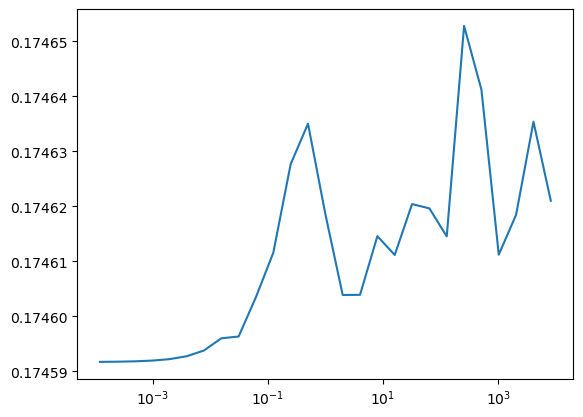

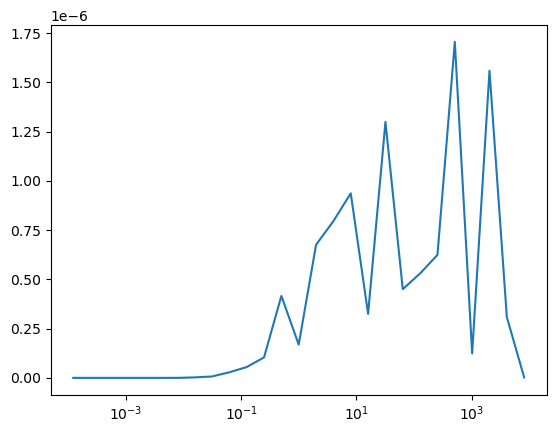

In [523]:
# Number of assets
n  = len(tickers)
env.n = n

# Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

# Subset the returns and factor returns corresponding to the current calibration period.
periodReturns = returns[returns.index <= calEnd]
periodFactRet = factorRet[factorRet.index <= calEnd]

# take the last available contextual observations
period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

env.periodReturns = periodReturns
env.periodFactRet = periodFactRet
env.period_daily_adjClose = period_daily_adjClose
env.period_Context = period_Context

# there should be a feature vector for each asset
assert len(period_Context) == n
# all the tickers should be aligned in the context and ticker dataset
assert (periodReturns.columns == period_Context.index).all()

current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
currentPrices = adjClose[current_price_idx]

# Subset the prices corresponding to the current out-of-sample test period.
periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
periodPrices = adjClose[periodPrices_idx]

assert len(periodPrices) == investPeriod
assert len(currentPrices) == 1
# Set the initial value of the portfolio or update the portfolio value


#----------------------------------------------------------------------
# Portfolio optimization
# You must write code your own algorithmic trading function
#----------------------------------------------------------------------
# add in the estimation info

x = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);


# Update your calibration and out-of-sample test periods
# testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
# testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
# calEnd    = testStart - pd.offsets.DateOffset(days=1)
end_time = time.time()

In [492]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True, random_state=20)

In [54]:
kf.get_n_splits(period_Context)

5

In [55]:
for i, (train_index, test_index) in enumerate(kf.split(period_Context)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  1   2   3   4   5   6   7   8   9  10  11  12  14  15  17  18  19  21
  22  23  24  25  26  27  30  31  33  35  36  37  38  39  40  41  42  43
  44  45  46  48  49  50  51  52  54  55  56  57  58  59  60  64  65  66
  67  68  69  70  71  73  74  75  76  77  78  79  80  81  82  85  86  87
  88  92  93  94  96  97  98  99 100 101 103 105 106 108 109 110 111 113
 114 115 116 118 120 122 123 125 126 127 128 129 130 131 132 133 134 136
 137 138 139 140 141 142 143 144 146 147 149 150 151 153 155 156 157 158
 159 161 162 163 164 167 168 171 172 173 174 175 176 177 178 180 181 183
 184 185 186 187 188 190 191 193 194 195 196 198 199 200 201 202 203 204
 205 206 207 208 210 211 212 213 215 217 218 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 242 243 244 246 248 249
 250 251 252 253 254 255 257 259 260 262 263 264 266 267 268 270 271 272
 274 275 276 277 278 279 280 281 282 283 284 285]
  Test:  index=[  0  13  16  20  28  29  32  34  47

In [343]:
tickers[x > 0.001]

Index(['ATO', 'HRL', 'JNJ', 'NEM', 'PEP', 'UHS', 'UNH'], dtype='object')

In [333]:
x[x > 0.001]

array([0.14656086, 0.13351498, 0.37496575, 0.07260442, 0.13340568,
       0.03950458, 0.09944374])

In [331]:
period_Context.iloc[test_index]

,adjRet_mean_20,adjRet_median_20,adjRet_std_20,adjRet_q1_20,adjRet_q3_20,adjRet_mean_40,adjRet_median_40,adjRet_std_40,adjRet_q1_40,adjRet_q3_40,...,adjVolume_mean_250,adjVolume_median_250,adjVolume_std_250,adjVolume_q1_250,adjVolume_q3_250,adjVolume_mean_500,adjVolume_median_500,adjVolume_std_500,adjVolume_q1_500,adjVolume_q3_500
ticker,,,,,,,,,,,,,,,,,,,,,
ADI,0.002613,0.004068,0.015918,-0.003119,0.012565,0.003707,0.003318,0.020676,-0.005850,0.014601,...,3.840670e+06,3602300.0,1.429464e+06,2977125.00,4557000.00,3.870418e+06,3520250.0,1.964953e+06,2814700.00,4348325.00
ADM,-0.003882,0.000116,0.018911,-0.009176,0.008628,-0.000669,0.001384,0.020522,-0.010991,0.014116,...,6.210808e+06,5681650.0,2.895355e+06,4462550.00,7156450.00,6.166794e+06,5533450.0,3.542693e+06,4233475.00,7171825.00
ADSK,0.002431,0.002771,0.016496,-0.006548,0.014791,0.005403,0.004209,0.022017,-0.010152,0.016237,...,3.489474e+06,2844450.0,2.560745e+06,2105175.00,3977475.00,3.109868e+06,2643200.0,2.112620e+06,2021750.00,3532125.00
AFL,0.000164,-0.000521,0.009806,-0.004892,0.004834,0.000860,0.000150,0.011532,-0.005477,0.007187,...,5.571889e+06,5197500.0,2.627206e+06,3729750.00,6582150.00,4.655491e+06,4045300.0,2.458454e+06,2968000.00,5736650.00
ATO,-0.000659,-0.001593,0.008390,-0.005826,0.004571,0.000969,-0.000717,0.010726,-0.007107,0.008487,...,5.163960e+05,459400.0,2.588246e+05,357800.00,629300.00,4.244450e+05,365450.0,2.620369e+05,274325.00,505375.00
AVY,0.002522,0.003330,0.013421,-0.006825,0.011646,-0.000506,0.001323,0.016889,-0.009432,0.008294,...,1.058992e+06,895100.0,6.260380e+05,694950.00,1236175.00,7.872834e+05,676150.0,5.576605e+05,421525.00,976750.00
AXP,-0.004920,0.001324,0.018794,-0.019021,0.009925,0.000180,0.002509,0.023065,-0.016111,0.010227,...,9.727422e+06,8951750.0,4.707354e+06,6899150.00,11658350.00,7.509316e+06,6569000.0,4.329582e+06,4507325.00,9434725.00
BA,-0.001231,0.002580,0.014528,-0.005396,0.004269,0.002339,0.002681,0.016472,-0.006502,0.007387,...,6.412121e+06,5656700.0,2.987844e+06,4554925.00,7650225.00,5.328562e+06,4691850.0,2.636351e+06,3584300.00,6283950.00
BEN,0.000503,0.000474,0.016888,-0.007345,0.013721,-0.000286,-0.001172,0.022323,-0.016651,0.013721,...,5.127931e+06,4744204.0,2.186290e+06,3668178.00,6090606.00,4.185105e+06,3751653.0,1.983186e+06,2780402.00,5121755.00


# 3. Results